In [1]:
!git clone https://github.com/zxzhaixiang/QMDB


Cloning into 'QMDB'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 350 (delta 38), reused 46 (delta 17), pack-reused 265
Receiving objects: 100% (350/350), 245.52 MiB | 32.26 MiB/s, done.
Resolving deltas: 100% (151/151), done.
Checking out files: 100% (83/83), done.


In [0]:
datapath = './QMDB/data/processed_data/'

In [3]:
!pip install hiddenlayer

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pickle
import random
import scipy.signal as sp_signal
import pandas as pd
import seaborn as sns
from datetime import datetime
import re

from imblearn.over_sampling import RandomOverSampler

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
import scipy.stats

from IPython.display import HTML, display

import hiddenlayer as hl
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from torchvision import transforms

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ", device)

Device is  cuda


## Loading data and prepare data loader

In [0]:
def get_date_time_info(timestamps):
    dt_objs = [datetime.fromtimestamp(ts) for ts in timestamps]
    is_weekend = [1 if dt_obj.weekday()>=5 else 0 for dt_obj in dt_objs]
    hr_of_day = [dt_obj.hour for dt_obj in dt_objs]
    return is_weekend, hr_of_day

In [9]:
print('loading raw rating data..',end='')
rating_df = pd.read_csv(os.path.join(datapath,'ratings_with_kws.csv'), compression='gzip')

#print('Done\n {} total rating record loaded\n'.format(rating_df.shape[0]))

userIds = rating_df['userId'].unique()

loading raw rating data..

In [0]:
user_df = rating_df.groupby('userId', as_index=False).agg({
                      'movieId': [('num_movie_rated','count')],
                      'rating': [('user_ave_rating','mean'),('user_std_rating','std')]}).fillna(0)
user_df.columns.set_levels([item if item!='' else 'userId' for item in user_df.columns.levels[1]],level=1,inplace=True)
user_df.columns = user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)

In [0]:
rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({
                    'userId': [('num_rating', 'count')],
                    'rating': [('movie_ave_rating','mean'),('movie_std_rating', 'std')]})
rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)       

In [0]:
movie_df = pd.read_csv(os.path.join(datapath,'keywords_all.csv'))
movie_df = movie_df.merge(rating_by_movie_df, how='left',on='movieId').reset_index()
#movie_df.drop(columns='genres',inplace=True)
movie_df['genre_kws'] = movie_df['genre_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s).lower()) 
#movie_df['description_kws'] = movie_df['description_kws'].apply(lambda s: re.sub(r'\[|\]|\'| |"', '', s).lower()) 
#movie_df['cast_kws'] = movie_df['cast_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s)) 

#genres = {a for s in movie_df['genres'] for a in s.split('|')}
#print('{} number of movie genres exist. They are '.format(len(genres)), genres)
#genres_dict = dict(zip(genres, range(len(genres))))

In [49]:
movie_df['kws_all'].head(10)

0    light national boy comes jealousy friendship d...
1    sean satellite bob*ola ejection service sequel...
2    no_fa_ganes dvd michael bening douglas reiner ...
3    corruption story hopkins biography anthony sto...
4    pirate acting renny island hunt sexuality davi...
5    no_fa_ganes casino to joe movies cannibalism n...
6    bowling lrc lee british picture shakespeare de...
7    beals bruce tim storylines antonio tarantino y...
8    hell hilarious bat as oedekerk callow very ind...
9    money snipes sibling subway new brother train ...
Name: kws_all, dtype: object

In [32]:
genres_list = {a.lower() for s in movie_df['genre_kws'] for a in s.split(',')}
genres_list = list(genres_list)
print('{} number of movie genres exist. They are '.format(len(genres_list)), genres_list)
genres_dict = dict(zip(genres_list, range(len(genres_list))))

22 number of movie genres exist. They are  ['movie', 'fantasy', 'western', 'drama', 'family', 'thriller', 'history', 'fiction', 'war', 'adventure', 'crime', 'action', 'animation', 'romance', 'music', 'foreign', 'science', 'documentary', 'tv', 'horror', 'mystery', 'comedy']


In [0]:
genres = np.zeros((movie_df.shape[0], len(genres_list)))
for irow, s in enumerate(movie_df['genre_kws']):
    for j in [genres_dict[e] for e in s.split(',')]:
        genres[irow,j]=1

In [0]:
with open(os.path.join(datapath,'keyword_embedding.pkl'), 'rb') as f:
    kw_embedding = pickle.load(f)

In [0]:
kw_default_embedding = torch.zeros(1,1,64)
n=0
for key in kw_embedding:
    kw_embedding[key] = torch.FloatTensor(kw_embedding[key]).unsqueeze(dim=0).unsqueeze(dim=0)
    kw_default_embedding += kw_embedding[key]
    n+=1

kw_default_embedding/=n

In [0]:
kw_set = set(kw_embedding.keys())

In [0]:
kw_ind_by_movie = [[kw for kw in kws.split(' ')] for kws in movie_df['kws_all']]

In [0]:
nM      = movie_df.shape[0]
nU      = user_df.shape[0]
nR      = rating_df['rating'].unique().shape[0]
nRecord = rating_df['rating'].shape[0]

In [0]:
is_weekend, hr_of_day = get_date_time_info(rating_df['timestamp'].values)

In [0]:
U    = torch.tensor(rating_df['userId'].values,  dtype=torch.long).reshape(-1,1)
M    = torch.tensor(rating_df['qmdbId'].values, dtype=torch.long).reshape(-1,1)
R    = torch.tensor(rating_df['rating'].values, dtype=torch.float).reshape(-1,1)
G    = torch.tensor(genres, dtype=torch.float)

In [0]:
tensor_weekend = torch.tensor(is_weekend, dtype=torch.float).reshape(-1,1)
tensor_hr = torch.tensor(hr_of_day, dtype=torch.float).reshape(-1,1)

In [0]:
batch_size = 4096
validation_split = .1
shuffle_dataset = True
random_seed = 42

In [0]:
dataset_size = nRecord
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

In [0]:
ros = RandomOverSampler(random_state=random_seed)
train_idx_resampled, _ = ros.fit_resample(np.array(train_idx).reshape(-1,1), (R[train_idx].numpy()*2).reshape(-1).astype(int))
train_idx_resampled = list(train_idx_resampled.reshape(-1))

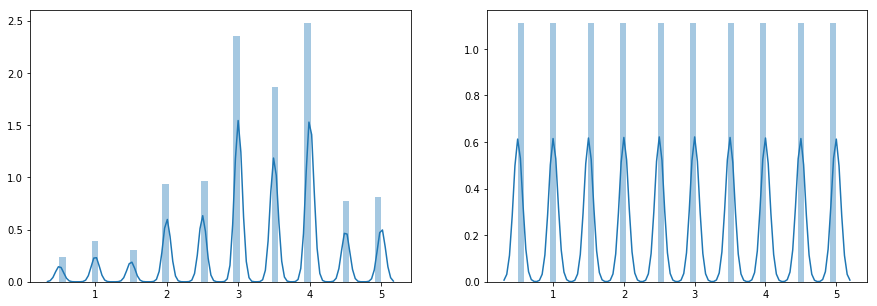

In [61]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(R[train_idx])
plt.subplot(122)
sns.distplot(R[train_idx_resampled])

In [62]:
print('Check if resampled indices covers all the original indices: {}'.format(set(train_idx)==set(train_idx_resampled)))

Check if resampled indices covers all the original indices: True


In [0]:
train_dataset = torch.utils.data.TensorDataset(
    U[train_idx_resampled], M[train_idx_resampled], R[train_idx_resampled],
    tensor_weekend[train_idx_resampled], tensor_hr[train_idx_resampled])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

In [0]:
val_dataset = torch.utils.data.TensorDataset(
    U[val_idx], M[val_idx], R[val_idx],
    tensor_weekend[val_idx], tensor_hr[val_idx])
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle = True)

## Build model

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
class NCF(nn.Module):
    def __init__(self, config):
        super(NCF, self).__init__()
        self.config = config
        self.user_dim = config['nUsers']
        self.movie_dim = config['nMovies']
        self.genres_dim = config['nGenres']
        
        self.g_latent_dim = config['genre_latent_dim']
        self.u_latent_dim = config['user_latent_dim']
        self.i_latent_dim = config['item_latent_dim']
        self.query_dim = config['Query_latent_dim']
        
        self.user_embedding = nn.Embedding(self.user_dim, self.u_latent_dim, 
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.movie_embedding = nn.Embedding(self.movie_dim, self.i_latent_dim,
                                           max_norm=1, scale_grad_by_freq = True)

        self.genres_layers = nn.Sequential(
                                nn.Linear(self.genres_dim, self.g_latent_dim)
        )
        
        self.fc_layers = nn.Sequential(
                            nn.Linear(self.u_latent_dim + self.g_latent_dim + self.query_dim + 2, self.u_latent_dim*2),
                            nn.Tanh(),
                            nn.Linear(self.u_latent_dim*2,self.u_latent_dim),
                            nn.Tanh(),
                            nn.Linear(self.u_latent_dim,self.u_latent_dim),
                            nn.Tanh())
        
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
    def forward(self, user_id, movie_id, genres, em_query, weekend, hr):
        
        user_em = self.user_embedding(user_id)
        movie_em = self.movie_embedding(movie_id)
        
        genres_em = self.genres_layers(genres).mean(dim=1, keepdim=True)
        
        total_em = torch.cat((user_em, genres_em, em_query, weekend.unsqueeze(dim=1), hr.unsqueeze(dim=1)), dim=2)
        final_em = self.fc_layers(total_em)
        return self.cos_sim(user_em,movie_em)*5, self.cos_sim(final_em,movie_em)*5
        

In [68]:
config = {'nUsers': nU, 'nMovies': nM, 
          'nGenres': len(genres_list),
          'user_latent_dim': 128, 'item_latent_dim': 128,
          'genre_latent_dim': 32, 'Query_latent_dim': 64
         }
print(config)


{'nUsers': 4380, 'nMovies': 3868, 'nGenres': 22, 'user_latent_dim': 128, 'item_latent_dim': 128, 'genre_latent_dim': 32, 'Query_latent_dim': 64}


In [0]:
CF = NCF(config).to(device)

In [0]:
CF_criterion = nn.MSELoss()
CF_optimizer = torch.optim.Adam(CF.parameters(), lr = 0.001, betas = (0.5, 0.999))

In [71]:
count_parameters(CF)

1164000

/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:586: UserWarning: ONNX export failed on ATen operator embedding_renorm because torch.onnx.symbolic.embedding_renorm does not exist
  .format(op_name, op_name))
/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:586: UserWarning: ONNX export failed on ATen operator cosine_similarity because torch.onnx.symbolic.cosine_similarity does not exist
  .format(op_name, op_name))


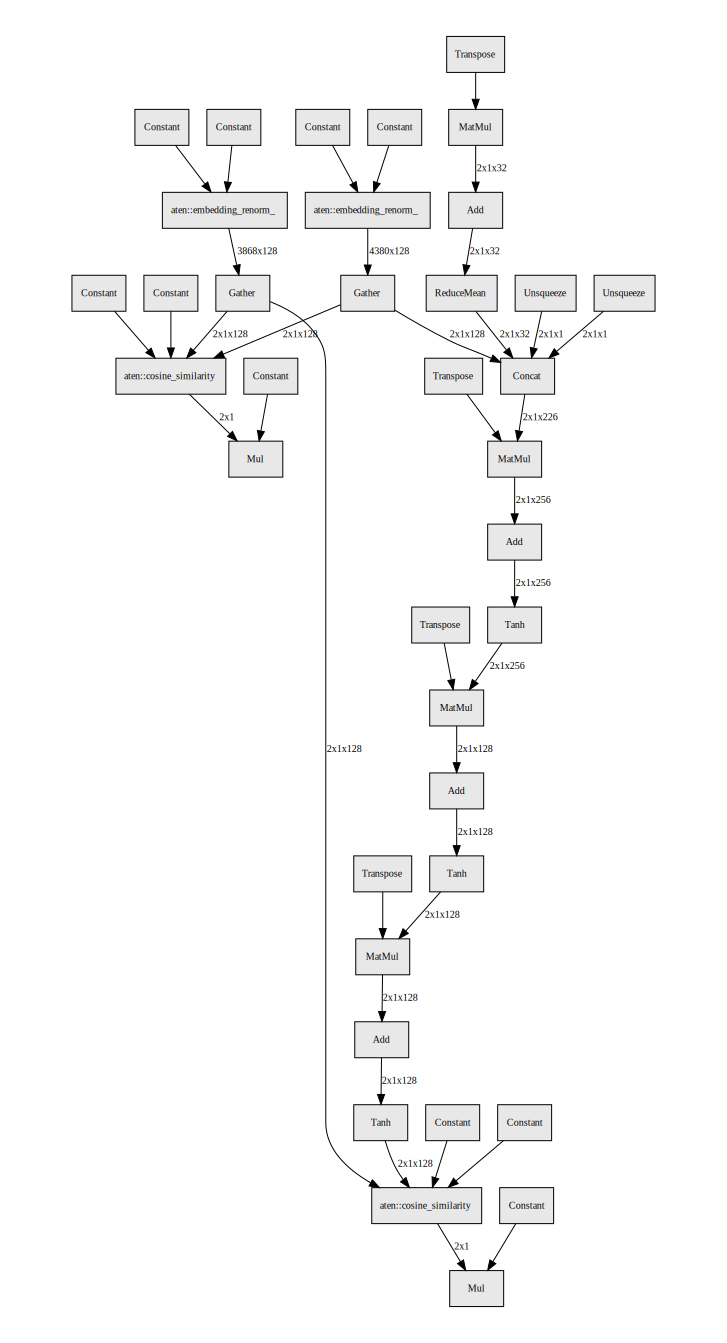

In [72]:
hl.build_graph(CF, (torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,config['Query_latent_dim']))).to(device), #query
   torch.FloatTensor(np.zeros((2,1))).to(device), #weekend
   torch.FloatTensor(np.zeros((2,1))).to(device))) #hr


In [73]:
CF(torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,config['Query_latent_dim']))).to(device), #query
   torch.FloatTensor(np.zeros((2,1))).to(device), #weekend
   torch.FloatTensor(np.zeros((2,1))).to(device)) #h

(tensor([[0.6651],
         [0.6651]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[-0.0519],
         [-0.0519]], device='cuda:0', grad_fn=<MulBackward0>))

## Training

In [0]:
class progress():
    def __init__(self,max = 100):
        self.mrange = max
        self.pbar = display(self.progress(0,M=self.mrange, loss=0), display_id = True)

    def update(self, i, loss=0):
        self.pbar.update(self.progress(i,M=self.mrange, loss=loss))
    
    def progress(self, value, loss=0, M=100):
        return HTML("""Training Mini Batch [{value}/{M}] Loss={loss:0.5f} <progress
                value='{value}'
                max='{M}',
                style='width: 80%'
            >
                90
            </progress>
              """.format(value=value,M=M,loss=loss))

In [0]:
train_losses = []
val_losses = []
train_losses_epoch = []
val_losses_epoch = []

In [76]:
nBatch_train = train_loader.__len__()
nBatch_val = val_loader.__len__()

print('{} mini-batches in training dataset, {} mini-batches in validation dataset'.format(nBatch_train, nBatch_val))

1647 mini-batches in training dataset, 83 mini-batches in validation dataset


In [0]:
epoch_num = 50

In [0]:
def lr_schedular(optimizer, epoch):
    if(epoch<2):
        lr = 0.001
    elif(epoch<10):
        lr = 0.0005
    elif (epoch<20):
        lr = 0.00025
    else:
        lr = 0.0001

    for param_group in optimizer.param_groups:
        param_group['lr']=lr

    return optimizer

In [0]:
G = G.to(device)

In [0]:
def get_query_tensor(movieIds):
    
    def get_embedding(kw_list):
        res = torch.zeros((1,1,config['Query_latent_dim']))
        n = 0
        for kw in kw_list:
            if kw in kw_set:
                res+=kw_embedding[kw]
                n+=1
        if n==0: 
            return kw_default_embedding
        return res/n

    res = []
    for i in movieIds.detach().cpu().numpy().flatten():
        kws = random.sample(kw_ind_by_movie[i], random.randrange(len(kw_ind_by_movie[i])))
        res.append(get_embedding(kws))

    return torch.cat(res,dim=0).to(device)

In [100]:
for epoch in range(epoch_num):
    print('Training epoch {}/{}'.format(epoch, epoch_num))
    pbar = progress(train_loader.__len__())
    
    train_loss = 0
    val_loss = 0
    tmp_loss = 0
    
    CF_optimizer = lr_schedular(CF_optimizer, epoch)

    for i,(users, movies, ratings, weekend, hr) in enumerate(train_loader):
        if i%5==0:
            pbar.update(i+1, tmp_loss)
        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        W, H = weekend.to(device), hr.to(device)
        Q = get_query_tensor(movies)
        
        rhat_final, rhat_user = CF(U,I, G[movies], Q, W, H)

        loss = CF_criterion(rhat_final, R)+CF_criterion(rhat_user, R)
        
        CF_optimizer.zero_grad()
        
        loss.backward()
        
        CF_optimizer.step()
        
        tmp_loss = loss.item()
        train_loss += loss.item()
        train_losses.append(loss.item())

    train_loss/=nBatch_train
    train_losses_epoch.append(train_loss)
    
    for i, (u,m,r, w, h) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        W, H = w.to(device), h.to(device)
        Q = get_query_tensor(m)

        rhat_final, rhat_user = CF(U, I, G[m], Q, W, H)
        loss = CF_criterion(rhat_final, R) + CF_criterion(rhat_user, R)

        val_loss += loss.item()
        val_losses.append(loss.item())
        
    val_loss/=nBatch_val
    val_losses_epoch.append(val_loss)
    
    print('epoch[{}/{}], train loss = {}, val loss = {}'.
         format(epoch, epoch_num, train_loss, val_loss))
    
    if (epoch%5==0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.subplot(122)
        plt.plot(val_losses, label='val loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.show()

Training epoch 0/50


KeyboardInterrupt: ignored

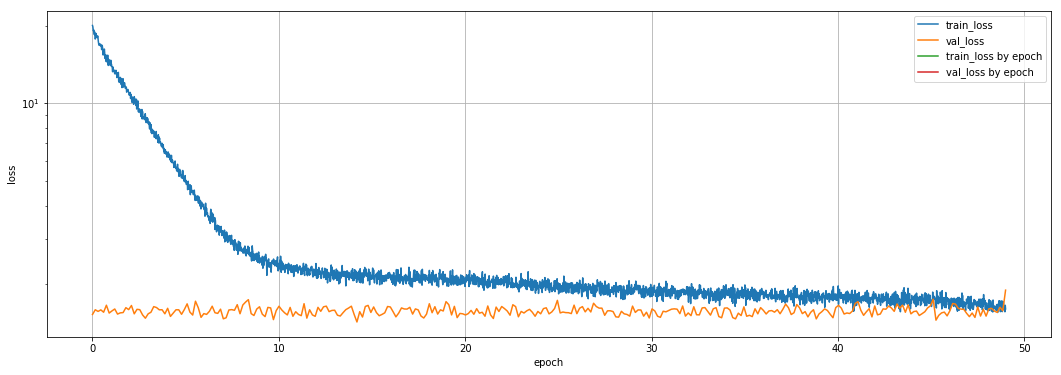

In [0]:
plt.figure(figsize=(18,6))

plt.plot(np.linspace(0,epoch_num-1, len(train_losses)),train_losses,label='train_loss')
plt.plot(np.linspace(0,epoch_num-1, len(val_losses)),val_losses,label='val_loss')
plt.plot(train_losses_epoch,label='train_loss by epoch')
plt.plot(val_losses_epoch,label='val_loss by epoch')
plt.yscale('log')
plt.legend(),plt.xlabel('epoch'), plt.ylabel('loss')
plt.grid(True)
#plt.ylim([0.01,0.05])

In [0]:
r_real = []
r_pred = []
        

for i, (_, u,m,r, y, w, h) in enumerate(val_loader):
    U, I, R = u.to(device), m.to(device), r.to(device)
    Y, W, H = y.to(device), w.to(device), h.to(device)
    Q = get_query_tensor(m)
    rhat_final, rhat_user = CF(U,I, G[m], Q,  W, H)
    
    rhat = .3*rhat_final+ .7*rhat_user
    r_real+=list(r.detach().cpu().numpy().reshape(-1))
    r_pred+=list(rhat.detach().cpu().numpy().reshape(-1))    
    if(i%20==0):
        print('{}/{}'.format(i,nBatch_val))

0/329
20/329
40/329
60/329
80/329
100/329
120/329
140/329
160/329
180/329
200/329
220/329
240/329
260/329
280/329
300/329
320/329


In [0]:
r_real = np.array(r_real) #, dtype=np.int)
r_pred = np.array(r_pred) #, dtype=np.int)
e = r_pred - r_real

In [0]:
r_pearson = scipy.stats.pearsonr(r_real, r_pred)[0]
r_spearman = scipy.stats.spearmanr(r_real, r_pred).correlation
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_real, r_pred)

In [0]:
print('average error = {}, std = {}'.format(e.mean(), e.std()))
print('mae = {}'.format(np.abs(e).mean()))
print('rmse = {}'.format(np.sqrt(np.square(e).mean())))

print('slope={}, r2={}'.format(slope, r_value))
print('pearson = {}, spearman = {}'.format(r_pearson, r_spearman))

average error = -0.24009092152118683, std = 0.8286311030387878
mae = 0.6651073694229126
rmse = 0.8627126812934875
slope=0.5444966162073619, r2=0.6405495683533055
pearson = 0.6405495683533041, spearman = 0.6205110816042666


(Text(0.5, 0, 'predict error'), Text(0, 0.5, 'count'))

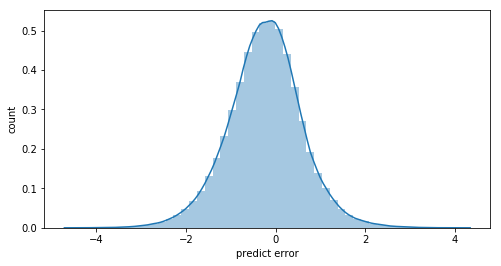

In [0]:
plt.figure(figsize=(8,4))
sns.distplot(r_pred-r_real, kde=True)
plt.xlabel('predict error'), plt.ylabel('count')

In [0]:
real = r.view(-1).detach().cpu().numpy()
pred = rhat.view(-1).detach().cpu().numpy()
users = U.detach().cpu().numpy().reshape(-1)
movies = I.detach().cpu().numpy().reshape(-1)
pd_df = pd.DataFrame({'real': real,'pred':pred, 'userId': users, 'movieId': movies})
pd_df = pd_df.merge(movie_df, how='left', on='movieId')
pd_df = pd_df.merge(user_df, how='left', on='userId')
#pd_df = pd_df.drop(columns = ML_Data.movie_genres)

In [0]:
pd_df.head(50)

,real,pred,userId,movieId,title,qmdbId,tmdbId,imdbId,year,genre_kws,description_kws,cast_kws,imgUrl,num_rating,movie_ave_rating,movie_std_rating,num_movie_rated,user_ave_rating,user_std_rating
0,3.0,3.824614,297,1471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,624,3.359776,0.701958
1,4.0,2.717946,3108,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1071,2.861811,1.218835
2,4.0,2.950315,1932,1129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,517,3.163443,1.067435
3,2.0,2.648385,447,2319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,925,3.383243,0.967765
4,4.0,3.551656,2815,1307,Boogie Nights,435.0,4995.0,118749.0,1997.0,drama,"lead,gay,rags,riches,industry,pornographic,act...","Wahlberg,Reynolds,C.,John,Reilly,Mark,Burt,Pau...",https://m.media-amazon.com/images/M/MV5BY2E2YW...,2714.0,3.718497,0.924825,652,3.230828,0.949177
5,3.0,3.927272,83,3327,Saving Silverman (Evil Woman),1164.0,10878.0,239948.0,2001.0,"crime,comedy,romance","epilogue,comedy,nudity,cameo,dark,harassment,d...","Black,Jason,Zahn,Jack,Biggs,Steve,Dennis,Dugan",https://m.media-amazon.com/images/M/MV5BYzhlY2...,879.0,2.657565,1.001381,1339,3.354742,0.655834
6,3.5,2.857252,3016,2741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1044,3.723180,0.867269
7,4.0,4.370518,3851,729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,854,3.694965,0.692269
8,0.5,2.136229,302,1940,In Dreams,685.0,28902.0,120710.0,1999.0,"thriller,drama","victim,kidnapping,hitchcockian,attempt,novel,b...","Stephen,Aidan,Bening,Annette,Quinn,Rea,Neil,Jo...",https://m.media-amazon.com/images/M/MV5BZmU2Mz...,312.0,2.633013,1.028891,1139,3.434592,0.897603
9,3.5,2.490781,3374,2885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,953,2.535677,0.755086


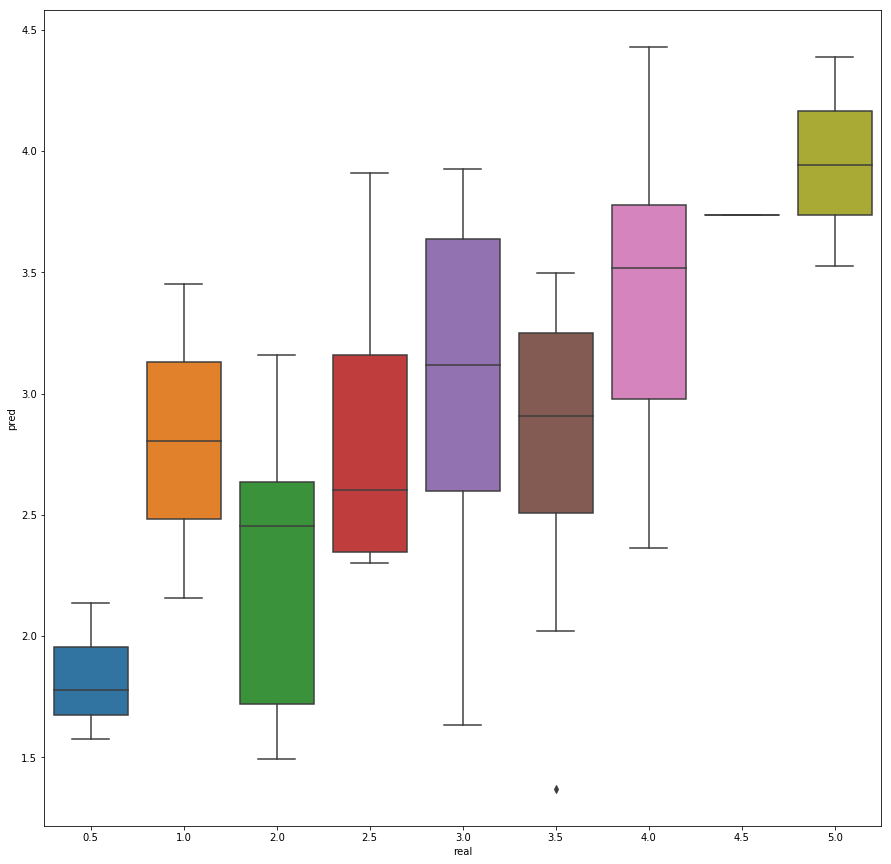

In [0]:
plt.figure(figsize=(15,15))
sns.categorical.boxplot(x="real", y="pred", data=pd_df)

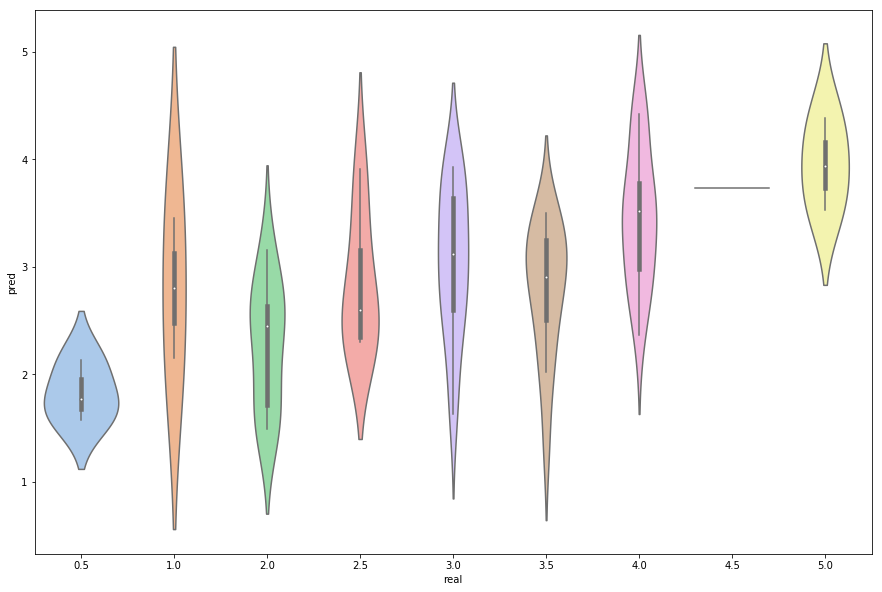

In [0]:
plt.figure(figsize=(15,10))
sns.categorical.violinplot(x="real", y="pred", split=True,  data=pd_df, palette="pastel")


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


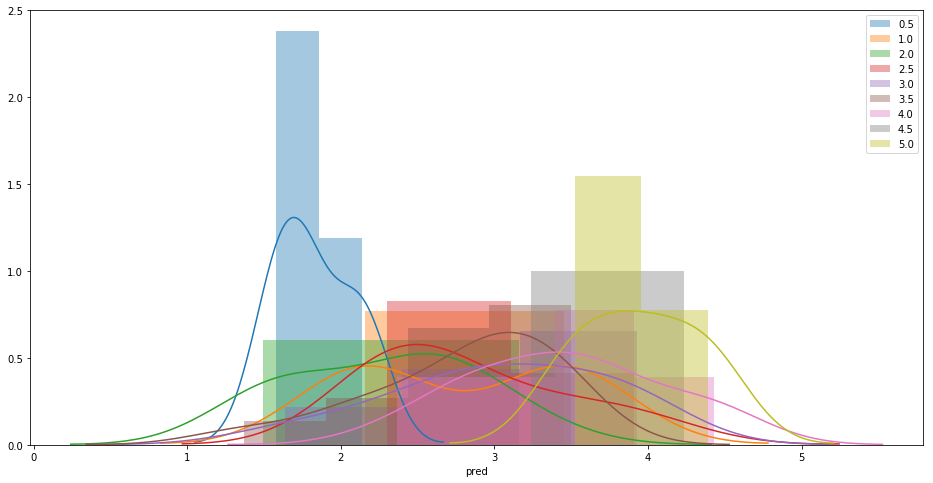

In [0]:
rs = list(pd_df['real'].unique())
rs.sort()
plt.figure(figsize=(16,8))
for r in rs:
    sns.distplot(pd_df['pred'][pd_df['real']==r], label=str(int(r*2)/2))
plt.legend()

In [0]:
genre_weight = CF.genres_layers[0].weight.detach().cpu().numpy().T

pca = decomposition.PCA(n_components = 5)
G_std = StandardScaler().fit_transform(genre_weight)
G_pca = pca.fit_transform(G_std)

(-2.6956193, 3.5871882)

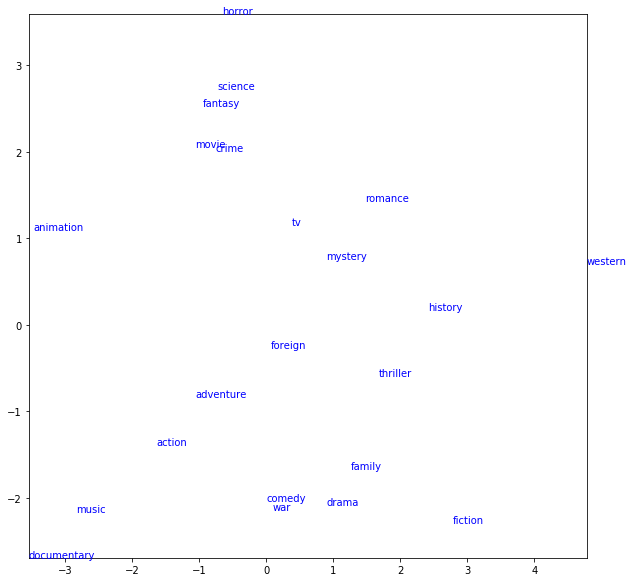

In [0]:
plt.figure(figsize=(10,10))

xs = []
ys = []

for key in genres_dict:
    i = genres_dict[key]
    x,y = G_pca[i,0], G_pca[i,1]
    xs+=[x]
    ys+=[y]
    plt.text(x,y,key,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()

In [0]:
L = np.linalg.norm(Movie_Em,axis=1,keepdims=True)

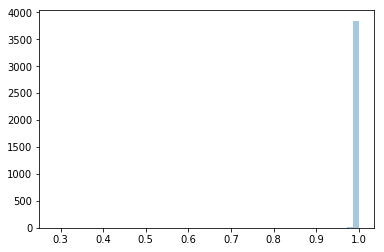

In [0]:
sns.distplot(L,kde=False)

In [0]:
pca = decomposition.PCA(n_components = 5)
M_std = StandardScaler().fit_transform(Movie_Em)
M_pca = pca.fit_transform(M_std)

(-8.488597912154665, 9.270381638856037, -5.917203188868714, 7.312048548630672)

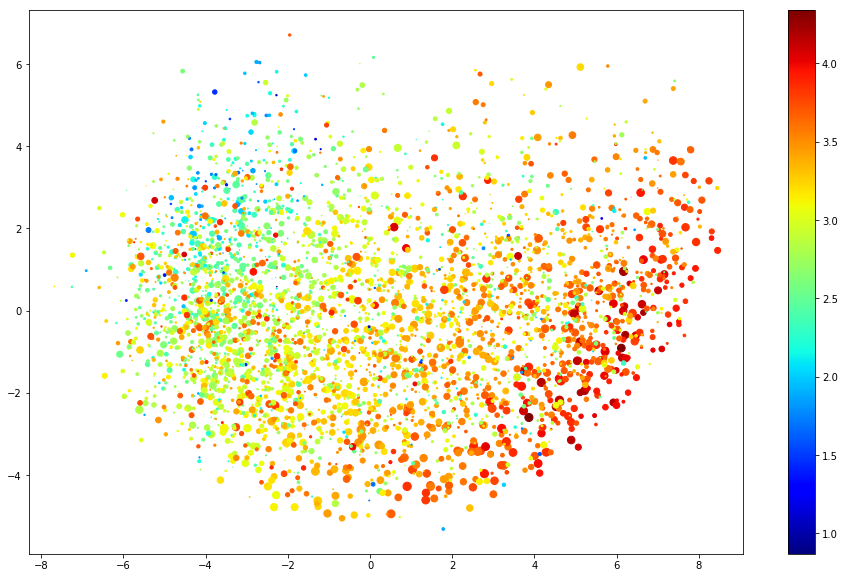

In [0]:
plt.figure(figsize=(16,10))

ss = (movie_df['num_rating'].values - movie_df['num_rating'].min())/60

plt.scatter(M_pca[:,0], M_pca[:,1], c = movie_df['movie_ave_rating'].values, s = ss, cmap='jet')
plt.colorbar()
plt.axis('equal')

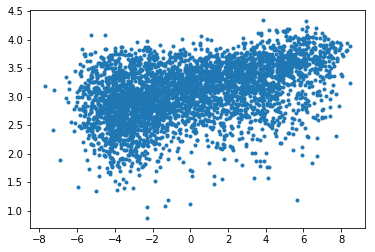

In [0]:
plt.plot(M_pca[:,0], movie_df['movie_ave_rating'],'.')

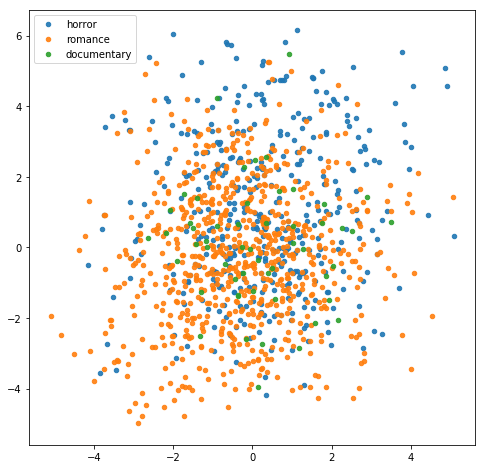

In [0]:
plt.figure(figsize=(8,8))
#for g in ML_Dataset.movie_genres:
for g in ['horror','romance','documentary']:
    i_g = genres_dict[g]
    ind = np.where(genres[:,i_g]==1)[0].tolist()
    plt.scatter(M_pca[ind,2], M_pca[ind,1],label=g,s=20, alpha=0.9)
plt.legend()

(-4.9443545, 4.2714114)

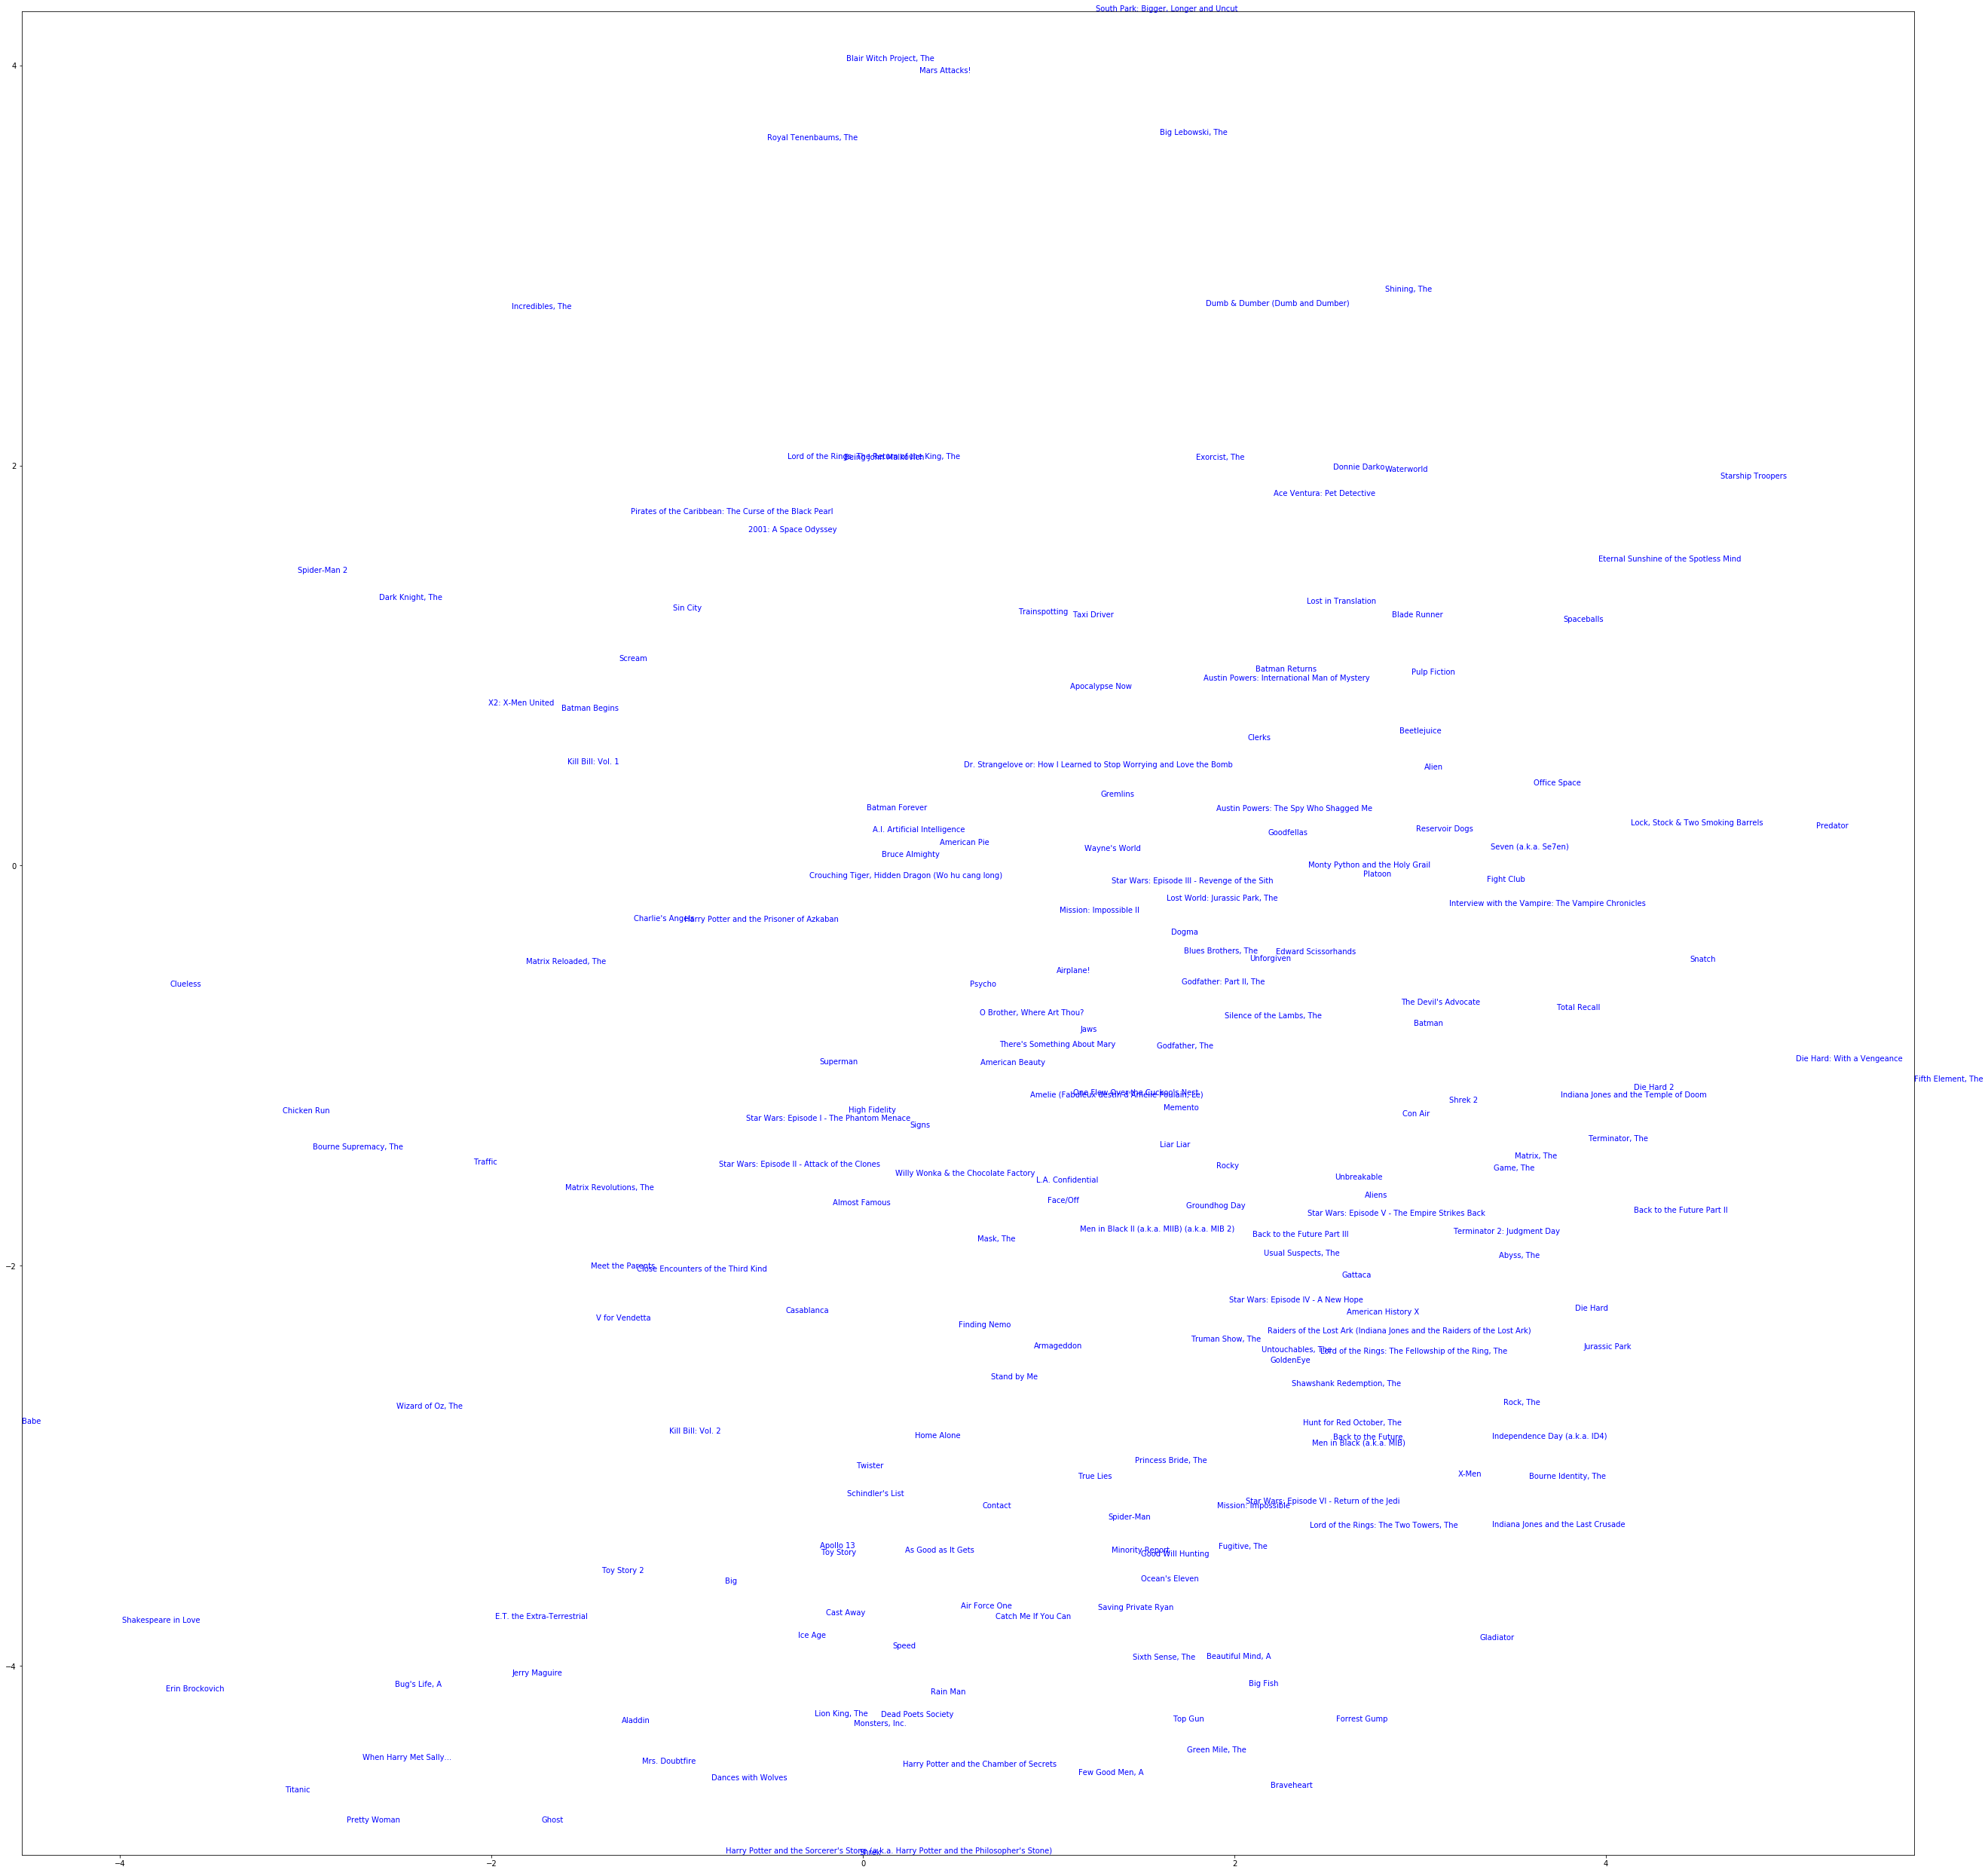

In [0]:
TopMovies_id = movie_df['num_rating'].nlargest(200).index.values

plt.figure(figsize=(45,45))
#plt.scatter(M_pca[:,0], M_pca[:,1])

xs = []
ys = []

for i in TopMovies_id:
    t = movie_df['title'][i]
    x,y = M_pca[i,2], M_pca[i,1]
    xs+=[x]
    ys+=[y]
    #if(x>xlim[0] and x<xlim[1] and y>ylim[0] and y<ylim[1]):
    plt.text(x,y,t,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = Movie_Em/L

In [0]:
Movie_S = np.matmul(Movie_Em, Movie_Em.T)

In [0]:
for i in range(50):
    movie_id = TopMovies_id[i]
    t = movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(movie_df['movie_ave_rating'][tmp_id]>2.5):
            t = movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Hammer, The
   Shawshank Redemption, The
   Lord of the Rings: The Fellowship of the Ring, The
   Mona Lisa Smile
   Grown Ups
   Terminator 2: Judgment Day
   Usual Suspects, The
   Star Wars: Episode V - The Empire Strikes Back
   Fight Club
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
   Star Wars: Episode IV - A New Hope

Movie:Forrest Gump
   Survivor
   Braveheart
   Green Mile, The
   Gladiator
   Sixth Sense, The
   Beautiful Mind, A
   Few Good Men, A
   Good Will Hunting
   Rain Man
   Bourne Identity, The
   American History X

Movie:Back to the Future
   Terminator 2: Judgment Day
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
   Star Wars: Episode IV - A New Hope
   Die Hard
   Terminator, The
   Star Wars: Episode V - The Empire Strikes Back
   Shawshank Redemption, The
   Lord of the Rings: The Two Towers, The
   Lord of the Rings: The Fellowship of the Ring, The
   Indiana Jones and the Last 